# HarvestStat Data Profiling - Mozambique

In [23]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [24]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32736' # Mozambique
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/MZ_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Mozambique',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best',
    'data_usage_policy':'Public'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
print(df.groupby(['status','collection_status','data_usage_policy']).size().reset_index(name='count'))
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1990	 | MZ1990A1 | 11	| MZ1990A2	| 142	| nan	| 0	|
| 2013	 | MZ2013A1 | 11	| MZ2013A2	| 155	| nan	| 0	|
| 2016	 | MZ2016A1 | 11	| MZ2016A2	| 157	| nan	| 0	|
| 2021	 | MZ2021A1 | 11	| MZ2021A2	| 158	| nan	| 0	|
----------------------------------------------- #
                  status collection_status data_usage_policy  count
0              Collected         Published     FEWS NET Only   2534
1              Collected         Published            Public   9369
2  Missing Historic Data         Published     FEWS NET Only      4
3  Missing Historic Data         Published            Public    417
4                No Data           No Data     FEWS NET Only      4
5          Not Available         Published     FEWS NET Only     57
6          Not Available         Published            Public   1880
7          Not Collected         Published     FEWS NET Only   29

In [25]:
# Manual Pre-processing before Sweeping --------- #
# Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# Change the season name
df['season_name'] = df['season_name'].replace({'Main harvest': 'Main'})

#Drop the hundreds of blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]
# There are rows that are direct duplicates (same value) 
# with slightly different source data names for the same source
# we will keep the more recent of these entries
rows = ['fnid','crop_production_system','season_year', 'product','indicator']
df['collection_date'] = pd.to_datetime(df['collection_date'])
df = df.sort_values(by=['collection_date']).drop_duplicates(rows, keep='last').reset_index(drop=True)

# Drop Sweet Potatoes
#df = df[df['product'] != 'Sweet Potatoes']
# ----------------------------------------------- #

#As a temporary measure, drop production systems that are not "All"
df = df.loc[~(np.isin(df['crop_production_system'],['Small_and_medium_scale','large_scale']))]

#Change Cassava Annual season to Main to create a continuous time series


# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
# We don't use admin2 data, so drop the admin 2 field because it is only in half the files and is empty
shpCols = ['FNID', 'EFF_YEAR', 'COUNTRY', 'ADMIN0', 'ADMIN1', 'ADMIN1FR','ADMIN1SP', 'ADMIN1PT', 
            'ALIASES', 'geometry', 'area']
MZ_Admin1_1990 = MZ_Admin1_1990[shpCols]
MZ_Admin1_2013 = MZ_Admin1_2013[shpCols]

shape_used = pd.concat([MZ_Admin1_1990,MZ_Admin1_2013,MZ_Admin1_2016,MZ_Admin1_2021], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 9,369
2,618/2,618 "Yield" points are retained.
3,302/3,302 "Quantity Produced" points are retained.
3,449/3,449 "Area Planted" points are retained.
Current data points: 9,369

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1999 - 2022
57 grain types are found: Bambara groundnut, Banana (unspecified), Beans (Lima), Beans (Rosecoco), Beans (mixed), Beet, Cabbage (Unspecified), Capsicum frutescens,unspecified, Carrots, Cashew (unshelled), Cassava, Chili pepper (Unspecified), Cotton (Unspecified), Cowpea (unspecified), Cucumber, Eggplant, Garlic (fresh), Ginger, Green bean (fresh), Groundnuts (In Shell), Groundnuts (In Shell, Large), Groundnuts (In Shell, Small), Jute, Kale, Lettuce (Unspecified), Macadamia (unspecified), Maize Grain (White), Millet, Mung bean (unspecified), Okras (Fresh), Onions, Other root/tuber vegetable (unspecified), Paprika (unspe


- Mozambique crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-mozambique.png?itok=hpXyM51B)

![USDA](https://ipad.fas.usda.gov/countrysummary/images/MZ/cropcalendar/safrica_mz_calendar.png)

- comparison of boundaries

![image](../figures/MZ_admin_shapes.png)

- In Mozambique, basd on the FEWS NET data, there were two changes in administrative units: 1990, 2013, and 2021
- While the admin unit 1 doesn't change between 1990 and 2013, we will still need to map between FNIDs

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1990	 | MZ1990A1 | 11	| MZ1990A2	| 142	| 
| 2013	 | MZ2013A1 | 11	| MZ2013A2	| 154	| 
| 2016	 | MZ2016A1 | 11	| MZ2016A2	| 157	| 
| 2021	 | MZ2021A1 | 11	| MZ2021A2	| 158	|

- The data is all reported in a single main season
- While there is a shapefile for 2021, there is no crop data associated with the 2021 shapefile, so we use 2013 as the most recent shapefile

In [26]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = MZ_Admin1_2021.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [27]:
# Link admin boundaries ------------------------- #
link_1990, over_1990 = FDW_PD_CreateAdminLink(MZ_Admin1_1990, MZ_Admin1_2021, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2013, over_2013 = FDW_PD_CreateAdminLink(MZ_Admin1_2013, MZ_Admin1_2021, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2016, over_2016 = FDW_PD_CreateAdminLink(MZ_Admin1_2016, MZ_Admin1_2021, 'ADMIN1', 'ADMIN1', prod, epsg)
# Crop specific ratios
link_ratio_1990 = FDW_PD_RatioAdminLink(link_1990, prod, over_1990, mdx_pss)
link_ratio_2013 = FDW_PD_RatioAdminLink(link_2013, prod, over_2013, mdx_pss)
link_ratio_2016 = FDW_PD_RatioAdminLink(link_2016, prod, over_2016, mdx_pss)

link_merged = [ link_ratio_1990, link_ratio_2013, link_ratio_2016]

fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

CBR is considered for 'MZ1990A106' as no record found in: ['MZ2021A106']
CBR is considered for 'MZ2013A106' as no record found in: ['MZ2021A106']
CBR is considered for 'MZ2016A106' as no record found in: ['MZ2021A106']


In [28]:
# Manual correction ----------------------------- #
# Potential typo: 4.0 -> 40. Using an area of 4 results in sorghum yield >8 t/ha
area_new.loc[2015,pd.IndexSlice['MZ2021A105',:,'Sorghum','Main','04-01','04-01','All (PS)']] = 40
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Bambara groundnut': 'Bambara groundnut',
    'Banana (unspecified)':'Banana (unspecified)',
    'Beans (Lima)': 'Beans (Lima)',
    'Beans (Rosecoco)': 'Beans (Rosecoco)',
    'Beans (mixed)': 'Beans (mixed)',
    'Cashew (unshelled)': 'Cashew (unshelled)',
    'Cassava': 'Cassava',
    'Chili pepper (Unspecified)':'Chili pepper (Unspecified)',
    'Cotton (Unspecified)': 'Cotton',
    'Cowpea (unspecified)': 'Cowpeas',
    'Ginger': 'Ginger',
    'Green bean (fresh)': 'Green bean',
    'Groundnuts (In Shell)': 'Groundnuts (In Shell)',
    'Groundnuts (In Shell, Large)': 'Groundnuts (In Shell, Large)',
    'Groundnuts (In Shell, Small)': 'Groundnuts (In Shell, Small)',
    'Jute':'Jute',
    'Macadamia (unspecified)':'Macadamia (unspecified)',
    'Maize Grain (White)': 'Maize',
    'Millet': 'Millet',
    'Mung bean (unspecified)':'Mung bean (unspecified)',
    'Other root/tuber vegetable (unspecified)': 'Other root/tuber vegetable',
    'Paprika (unspecified)': 'Paprika',
    'Pigeon pea (Unspecified)': 'Pigeon Peas',
    'Pepper (Piper spp.)': 'Pepper (Piper spp.)',
    'Rice (Paddy)': 'Rice',
    'Sesame Seed': 'Sesame Seed',
    'Sorghum': 'Sorghum',
    'Soybean (unspecified)': 'Soybean',
    'Spanish peanut (in shell)': 'Spanish peanut',
    'Sugarcane (for sugar)': 'Sugarcane',
    'Sunflower Seed': 'Sunflower Seed',
    'Sweet Potatoes': 'Sweet Potatoes',
    'Sweet Potatoes (Non-Orange)': 'Sweet Potatoes (Non-Orange)',
    'Sweet Potatoes (Orange)': 'Sweet Potatoes (Orange)',
    'Tea leaves (Mixed)': 'Tea leaves',
    'Tobacco (unspecified)': 'Tobacco',
    'Virginia peanut (in shell)': 'Virginia peanut',
    'Wheat Grain': 'Wheat'
}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
for f, r in link_ratio.items():
    mdx = pd.MultiIndex.from_frame(r.index.to_frame().reset_index(drop=True).replace(product_category_custom))
    r.index = mdx
    link_ratio[f] = r
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Mozambique']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

# Save data
fn_out = '../data/crop/adm_crop_production_MZ.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_MZ.csv is saved.


# Visualization of production data

../figures/MZ_bar_natgrainprod_Main.png is saved.


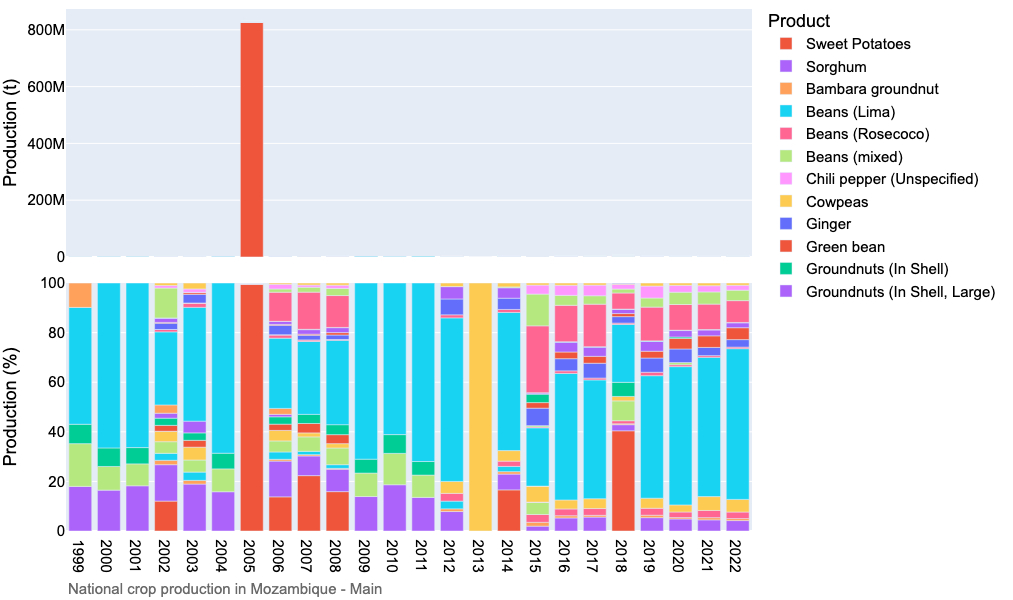

In [29]:
# Bar chart of national crop production
country_iso, country_name = 'MZ', 'Mozambique'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Cassava','Sweet Potatoes','Maize Grain (White)','Sorghum']
for season_name in ['Main']:
    footnote = 'National crop production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()

../figures/MZ_line_pay_Cassava_Annual.png is saved.


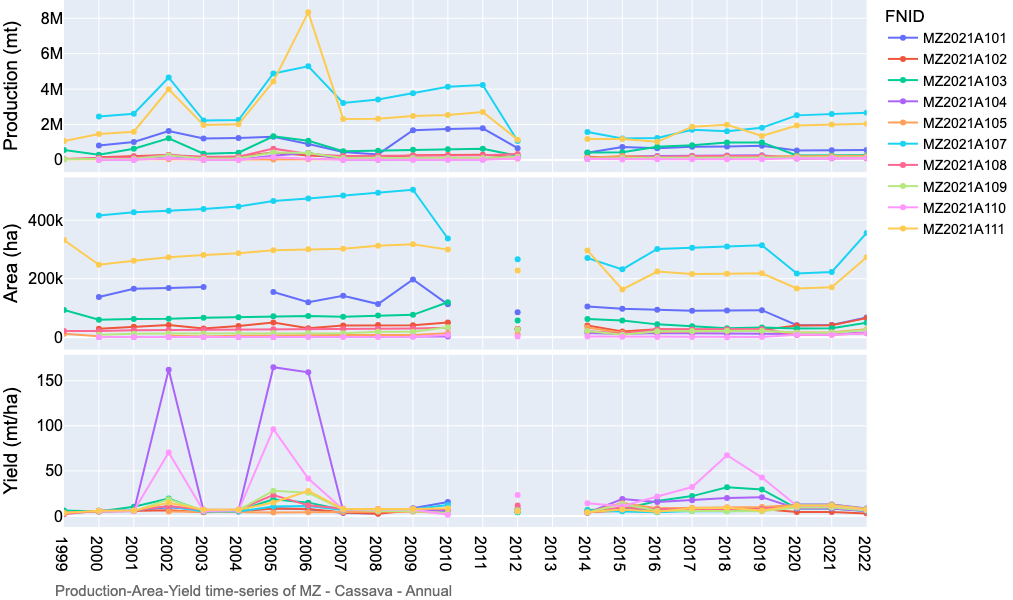

../figures/MZ_line_pay_Maize_Main.png is saved.


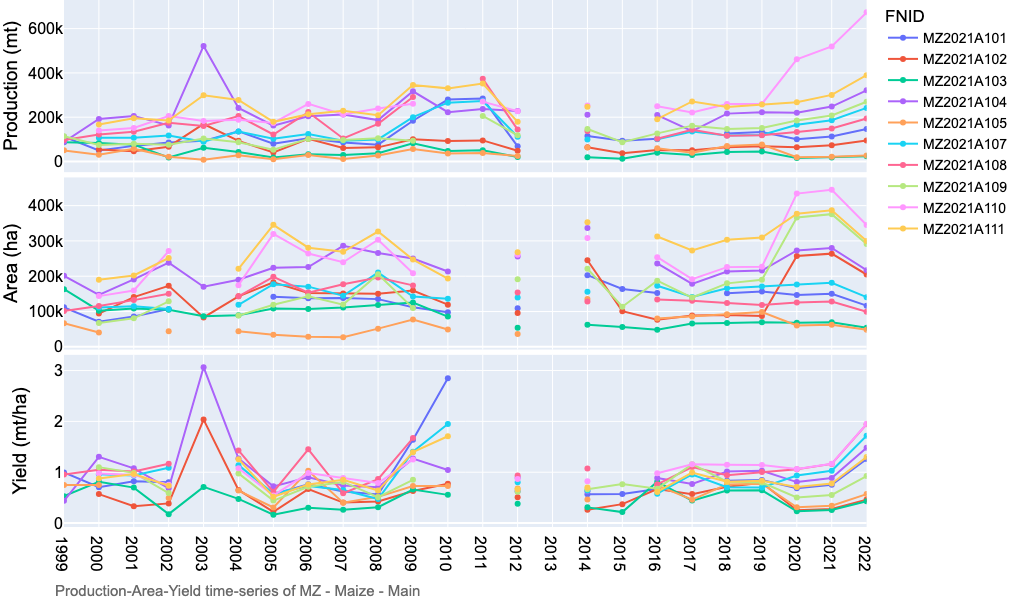

../figures/MZ_line_pay_Sorghum_Main.png is saved.


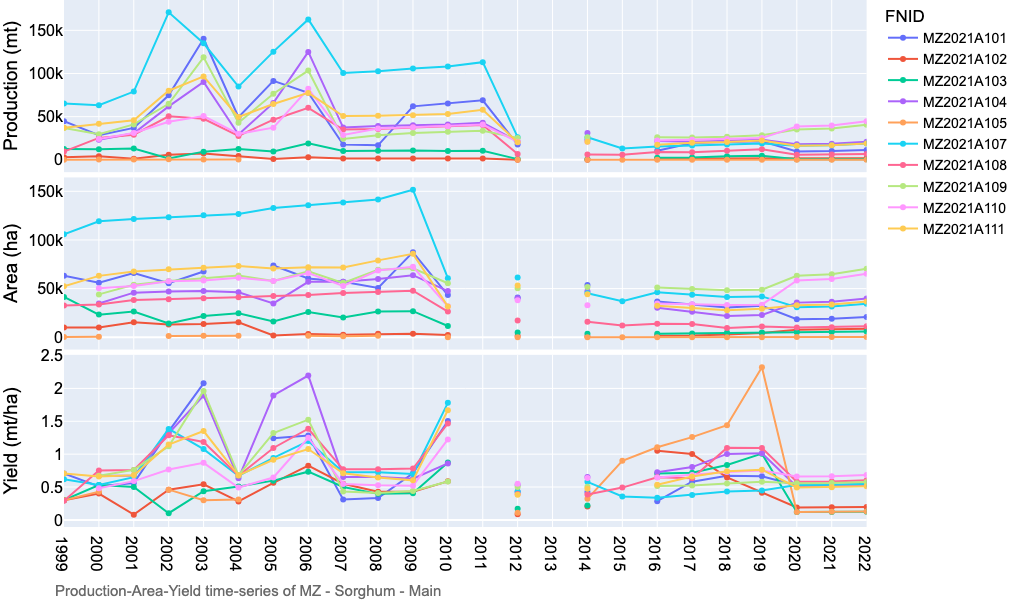

In [32]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name ='MZ', 'Mozambique'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Cassava','Annual'],
    ['Maize','Main'],
    ['Sorghum','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()